In [0]:
!pip install scrapbook
!pip install surprise


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [0]:
import os
import argparse
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics import roc_auc_score, log_loss
import sys
import surprise
from surprise import Dataset, Reader, accuracy, SVD
from surprise.model_selection import train_test_split, PredefinedKFold
from surprise.accuracy import rmse
import scrapbook as sb
from contextlib import contextmanager
import time
import gc
import argparse

# spark imports
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lower
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

import random
import numpy as np
# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

print(f"System version: {sys.version}")
print(f"Surprise version: {surprise.__version__}")

System version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Surprise version: 1.1.3


In [0]:
# initial spark
spark = SparkSession \
    .builder \
    .appName("Movie Recommender SVD") \
    .getOrCreate()

In [0]:
jdbcHostname = "dev-the-movie-system.database.windows.net"
jdbcDatabase = "dev-rcm-movie"
jdbcPort = 1433
jdbcUrl = "jdbc:sqlserver://{0}:{1};database={2}".format(jdbcHostname, jdbcPort, jdbcDatabase)
connectionProperties = {
"user" : "the-movie",
"password" : "a[mdH/M4<MHj,7W[",
"driver" : "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

In [0]:
# Đọc dữ liệu
movies_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[W_THE_MOVIE_D]", properties=connectionProperties)
display(movies_df)

MOVIE_ID MOVIE_NAME GENRE MOVIE_DATE COUNTRY URL_POSTER OVERVIEW DIRECTOR 1183993.0 Chamán [] 2023-09-05T00:00:00Z Peru https://image.tmdb.org/t/p/w500/qhGXZ16N4PaPpp5Rl0JBZnZtbJC.jpg The old Shaman makes his last trip to the Amazon jungle in search of a special beeswax for arrows that he learned to make when he had not yet been contacted by Western culture 1133349.0 Taungsu [] 2023-06-02T00:00:00Z Myanmar https://image.tmdb.org/t/p/w500/hjhlBZdH8brapjIUdr4qkwcCb9o.jpg Plot Unknown 974169.0 Day 13 ['Thriller', 'Horror'] 2023-04-21T00:00:00Z Egypt https://image.tmdb.org/t/p/w500/cFmSA1lAoK34WtgqYoPO7vRgJN9.jpg A horror feature that tells the story of Ezz El-Din, who returns from abroad after many years, looking for his family, and while staying at his family's mansion, he discovers an unexpected adventure. Wael Abdullah 1037348.0 As Long As We Both Shall Live ['Drama', 'Romance', 'Fantasy'] 2023-03-17T00:00:00Z Japan https://image.tmdb.org/t/p/w500/yYbBsAA1eh3hioW4Jm0G775TZk0.jpg An unhappy young woman from an abusive family is married off to a fearsome and chilly army commander. But the two learn more about each other, love may have a chance. Ayuko Tsukahara 1062343.0 No Direction Home ['Drama'] 2023-02-11T00:00:00Z Japan https://image.tmdb.org/t/p/w500/crIDprSM6OnuLQGA1yxkOb8XMfk.jpg After missing the last train after their best friend’s wedding, Ko, Reiji, and Yasumasa are dropped off at a small train station in the countryside. A teacher, a salaried worker, and an aspiring painter, three people with vague anxieties walk the dark streets at night and pour out their thoughts. Taishi Nakagawa 1110405.0 In My Heart ['Drama', 'Romance'] 2022-11-23T00:00:00Z Germany https://image.tmdb.org/t/p/w500/sWgVN4jdn9N2j25BDjny8CYcJ2M.jpg Adele is afraid of the outside world. She is depressed. She can't leave her house anymore. So Alice joins her to understand what is eating away at her. Victor Boulenger 1172108.0 My Therapist Gives Me A Special Treatment [] 2022-08-08T00:00:00Z https://image.tmdb.org/t/p/w500/l7tiNH4Nsz0eiDelpTeaqIj5Idm.jpg Therapists are an essential part of life for some folks, and watching this wonderful offering from the guys at Amsterdam Amateurs its pretty obvious why especially if the treatment theyre offering is any way like the kind that these fellows provide. No wonder the hardcore sluts here are so keen to make their sessions part and parcel of their weekly routines. Zoe Davis, Rachel Rose and Debby Pleasure just can't wait to get down on that couch; opening up like never before, and taking every thick, meaty inch of cock thats on offer in the process. It's more than enough to leave them changed women; as they climax again and again on those penetrating ramrods. In short, a top-notch mental and physical workout each and every time! 990393.0 Walk with the Storm ['Documentary', 'Family'] 2022-06-18T00:00:00Z https://image.tmdb.org/t/p/w500/zvCPk0WuFhOLOJCsUEMd5VuiDfk.jpg In a small town, the funeral of a matriarch brings about the reunion of family members, many returning to the village after leading new lives elsewhere, some no longer speaking the language of the native land. With the passage of time, the big clan becomes fragmented as members, like other modern Chinese in mainland China, face changes in lives, ideals, and family structures. The occasion becomes a hot ground for deals and negotiations that are inevitable amid the rapid development of China, where family members prosper while relationships become calculated. Still, a funeral procession amid an impending storm requires them, already down different paths, to walk together. Lam Tung-hei 973667.0 Garten sprengen [] 2022-04-05T00:00:00Z Austria Shortly after their arrival in California, they became the target of intense FBI investigations, which resulted in an elaborate series of wiretapping, tailing, and burglaries that would last six years. Veronika Eberhart 933238.0 Footsteps ['Thriller', 'Horror'] 2022-01-31T00:00:00Z https://image.tmdb.org/t/p/w5

In [0]:
users_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[W_USER_D]", properties=connectionProperties)
display(users_df)

USER_ID FULL_NAME GENDER BIRTH_DATE ADDRESS USERNAME PASSWORD ID0001 Triệu Văn Kiểm female 13/06/2001 Bình Dương, Việt Nam christopherduran 9^AhGo^!!5 ID0002 Bùi Quốc Lĩnh male 29/04/2005 Bình Dương, Việt Nam dware *Fnj$6SxAC ID0003 Mạc Văn Tuân female 16/06/2002 Hậu Giang, Việt Nam sarah83 _h6JFi$fd_ ID0004 Tôn Quốc Phục male 27/03/2008 Đắk Nông, Việt Nam andrewszachary 6O)59D3soX ID0005 Phạm Doãn Thắng female 10/05/1982 Long An, Việt Nam browneric i1Rz6xSC!l ID0006 Nguyễn Đăng Tùng male 02/07/2004 Yên Bái, Việt Nam edward58 T9@aXWs3&# ID0007 Mạc Hữu Hoàn male 07/04/2003 Sơn La, Việt Nam ulawrence #*M0AWhj5q ID0008 Trịnh Quốc Doanh female 28/12/1991 Đồng Nai, Việt Nam vwarren #U@4UwOf6B ID0009 Hồ Quốc Em female 02/11/2000 Gia Lai, Việt Nam pfowler RJK9CKt9l+ ID0010 Hoàng Văn Toản male 23/08/1999 Hải Phòng, Việt Nam jmccarthy qG0P1gjon( ID0011 Đinh Quốc Toàn female 15/08/1999 Sơn La, Việt Nam brianchen 1yDFfnt4#6 ID0012 Tôn Hữu Hoàn female 16/11/2003 Đắk Nông, Việt Nam ctran )9RjOVRqFJ ID0013 Phan Thị Triều female 12/06/1989 Long An, Việt Nam hollyanderson 3nMV&zgX!a ID0014 Phan Văn Quyền male 08/10/1995 Hải Phòng, Việt Nam jamesjacobs %aCw_9@hr3 ID0015 Hoàng Văn Tùng male 25/04/1999 Trà Vinh, Việt Nam claudialopez )d*1Q6cy*8 ID0016 Nguyễn Hữu San female 07/01/2004 Sóc Trăng, Việt Nam matthewbaker 2gVM(2kd)2 ID0017 Trần Ngọc Tùng female 15/09/1989 Trà Vinh, Việt Nam rodgersjoshua %j8LxnjHAe ID0018 Hồ Đăng Toản female 19/01/2004 Bắc Kạn, Việt Nam brandimoore (9fVJIHh_N ID0019 Tôn Văn Doanh female 26/02/1998 Phú Thọ, Việt Nam spencejessica %YmKNzNUy9 ID0020 Mạc Quốc Ly male 09/08/1998 Khánh Hòa, Việt Nam robinlewis @c4l7X*yLa ID0021 Phạm Văn Dung female 31/03/1999 Hậu Giang, Việt Nam taylor40 yMkY6lCh$H ID0022 Trần Doãn Độ male 08/08/2002 Nam Định, Việt Nam scott49 cO0INuho#^ ID0023 Trần Doãn Doanh male 14/09/2000 Hậu Giang, Việt Nam christiangrant a(5WlFhKny ID0024 Phan Đăng Thắng female 13/11/2003 Sóc Trăng, Việt Nam gkent VI8dDmN8)S ID0025 Hoàng Hữu Ly male 13/05/2005 Lào Cai, Việt Nam allison86 URY$5RYsb) ID0026 Ngô Thị Tuấn female 03/02/1999 Phú Thọ, Việt Nam emilywright _LVPcg0QI3 ID0027 Triệu Doãn Doanh female 24/07/2007 Bình Phước, Việt Nam sabrina23 kj1Wt_%z+w ID0028 Ngô Ngọc Thắng female 02/02/2005 Quảng Bình, Việt Nam nicholas40 ^r8U(wgc04 ID0029 Ngô Quốc Triều male 09/08/2004 Bình Định, Việt Nam williamstracy S1r3Uub$)@ ID0030 Ngô Thị Tuấn male 24/10/2000 Hà Giang, Việt Nam deborahlee (_Mt@l8G%0 ID0031 Trần Hữu Doanh male 16/08/2009 Hòa Bình, Việt Nam jarvisheather ^8OSl2es0W ID0032 Ngô Quốc Thuyết male 13/05/2001 Quảng Bình, Việt Nam jonathan82 $3N@AJjs6w ID0033 Triệu Quốc Sơn male 23/04/2003 Hải Dương, Việt Nam daniel60 _H7Kow92dC ID0034 Tôn Thị Tuân male 15/08/1997 Phú Yên, Việt Nam christensenkim &4#EMKD(d5 ID0035 Phan Quốc Thắng male 10/03/1983 An Giang, Việt Nam bentleylorraine __h3WJopV@ ID0036 Hoàng Quốc Ánh female 05/02/2003 Hòa Bình, Việt Nam gwalker +1gK)^Tz7s ID0037 Phan Quốc Lĩnh male 09/03/1999 Hà Nội, Việt Nam smccoy +0$(CqDAeG ID0038 Bùi Ngọc Thuyết female 30/11/2005 Bắc Ninh, Việt Nam kevinshea (6*&wk6tzA ID0039 Hồ Doãn Toàn male 13/02/1998 Khánh Hòa, Việt Nam francisjoseph Id6X8XnM^* ID0040 Triệu Văn Em female 18/09/2003 Nam Định, Việt Nam leeellen UH4CZDdof! ID0041 Tôn Văn Tùng female 14/12/1991 Hòa Bình, Việt Nam nelsonrobin Uwk_6Qkm(4 ID0042 Hoàng Doãn Quyền female 10/11/2004 Điện Biên, Việt Nam daltonsimmons F&jW1SDNPh ID0043 Hồ Thị Cảnh male 11/04/2005 Đồng Nai, Việt Nam cstephens hq%O3TjpaX ID0044 Hoàng Văn Kiểm male 11/07/1999 Đắk Lắk, Việt Nam annette24 w!2BEi)iS^ ID0045 Lý Văn Ánh female 16/08/1999 Bắc Ninh, Việt Nam melissa14 h7+*9XiLn& ID0046 Lý Đăng Doanh female 17/05/2004 Bình Định, Việt Nam cainregina 2%W5OKlgN6 ID0047 Trịnh Quốc Kiểm female 04/06/1999 Bến Tre, Việt Nam hudsonluis 7c4hFy)z@l ID0048 Lê Doãn Thuyết male 14/08/2003 Bình Phước, Việt Nam bradley80 ^JNNZjzU52 ID0049 Hồ Quốc Tuân female 16/03/1999 Thái Bình, Việt Nam kaylayu Y&$2VuGlPl ID0050 Tôn Ngọc Ánh female 11/09/1998 Bế

In [0]:
history_watch_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[WATCH_MOVIE_F]", properties=connectionProperties)
history_watch_df = history_watch_df.withColumnRenamed("MOVIE-ID", "MOVIE_ID")
display(history_watch_df)

USER_ID MOVIE_ID LIKE_MOVIE DATE_WATCH RATING ID0001 488.0 false 23-11-2023 2.0 ID0001 56734.0 false 23-05-2023 4.0 ID0001 144852.0 false 15-10-2023 6.0 ID0001 25072.0 false 20-03-2023 1.0 ID0001 13.0 false 26-08-2023 2.0 ID0001 6968.0 true 01-11-2023 10.0 ID0001 58006.0 true 26-05-2023 9.0 ID0001 1640.0 false 22-02-2023 2.0 ID0001 78798.0 false 13-08-2023 5.0 ID0001 504.0 false 29-09-2023 4.0 ID0001 27163.0 false 04-06-2023 5.0 ID0001 4808.0 false 09-09-2023 6.0 ID0001 45379.0 true 15-02-2023 7.0 ID0001 61263.0 false 20-11-2023 3.0 ID0001 6365.0 true 31-03-2023 7.0 ID0001 29369.0 false 09-03-2023 5.0 ID0001 240145.0 false 19-01-2023 1.0 ID0001 55636.0 true 28-03-2023 8.0 ID0001 4960.0 false 14-06-2023 3.0 ID0001 27972.0 true 31-10-2023 10.0 ID0001 10912.0 true 07-04-2023 7.0 ID0001 12763.0 true 20-08-2023 7.0 ID0001 61134.0 true 17-03-2023 10.0 ID0002 31167.0 true 30-01-2023 7.0 ID0002 7180.0 true 16-02-2023 7.0 ID0002 30614.0 true 26-10-2023 10.0 ID0002 819.0 true 18-11-2023 9.0 ID0002 155.0 false 05-02-2023 1.0 ID0002 4959.0 false 15-01-2023 3.0 ID0002 8338.0 false 21-03-2023 5.0 ID0002 11662.0 false 01-04-2023 1.0 ID0002 21041.0 false 13-06-2023 1.0 ID0002 62.0 true 21-06-2023 9.0 ID0002 956.0 false 19-04-2023 1.0 ID0002 13022.0 false 26-06-2023 3.0 ID0002 43135.0 false 20-05-2023 1.0 ID0002 9030.0 false 14-07-2023 4.0 ID0002 13548.0 false 19-11-2023 5.0 ID0002 27428.0 false 06-10-2023 3.0 ID0002 10431.0 true 10-11-2023 10.0 ID0002 11701.0 false 18-06-2023 4.0 ID0002 85.0 true 27-08-2023 8.0 ID0002 106725.0 true 01-11-2023 10.0 ID0002 10859.0 false 07-04-2023 6.0 ID0002 11006.0 false 11-11-2023 5.0 ID0002 59817.0 false 04-01-2023 6.0 ID0002 78147.0 false 04-05-2023 1.0 ID0002 69597.0 false 07-10-2023 2.0 ID0002 40036.0 false 17-09-2023 3.0 ID0002 933238.0 false 17-08-2023 2.0 ID0002 41419.0 true 15-09-2023 10.0 ID0002 20089.0 false 24-04-2023 1.0 ID0002 66.0 true 04-03-2023 7.0 ID0002 36669.0 false 13-05-2023 3.0 ID0002 2165.0 false 09-08-2023 1.0 ID0002 77700.0 false 30-07-2023 3.0 ID0002 53714.0 false 25-03-2023 3.0 ID0002 15135.0 false 16-09-2023 5.0 ID0002 66107.0 false 28-08-2023 4.0 ID0002 4174.0 true 16-01-2023 9.0 ID0002 169337.0 true 04-09-2023 10.0 ID0002 4937.0 false 21-10-2023 5.0 ID0002 54812.0 false 27-09-2023 2.0 ID0002 9281.0 false 29-04-2023 4.0 ID0002 45379.0 false 22-10-2023 1.0 ID0002 6968.0 false 22-07-2023 4.0 ID0002 17288.0 true 13-02-2023 8.0 ID0002 3124.0 true 16-10-2023 7.0 ID0003 886.0 false 17-01-2023 2.0 ID0003 3087.0 false 27-03-2023 4.0 ID0003 2169.0 false 15-11-2023 4.0 ID0003 22123.0 false 23-01-2023 3.0 ID0003 55636.0 true 07-03-2023 8.0 ID0003 116.0 false 22-10-2023 3.0 ID0003 39545.0 false 20-06-2023 4.0 ID0003 12132.0 true 05-06-2023 9.0 ID0003 6384.0 true 26-07-2023 9.0 ID0003 4688.0 true 16-02-2023 10.0 ID0003 19.0 false 24-11-2023 4.0 ID0003 1067849.0 false 03-09-2023 1.0 ID0003 155.0 false 10-09-2023 4.0 ID0003 15336.0 false 27-01-2023 5.0 ID0003 240145.0 false 26-07-2023 5.0 ID0003 66.0 false 03-04-2023 3.0 ID0003 37995.0 true 21-08-2023 9.0 ID0003 851784.0 false 29-09-2023 6.0 ID0003 27811.0 false 15-01-2023 4.0 ID0003 108.0 true 10-04-2023 10.0 ID0003 52851.0 true 18-06-2023 7.0 ID0003 4512.0 true 30-07-2023 10.0 ID0003 1248.0 false 11-07-2023 2.0 ID0003 4959.0 false 27-06-2023 1.0 ID0003 1269.0 true 19-03-2023 8.0 ID0003 49001.0 false 01-08-2023 6.0 ID0003 11006.0 false 18-02-2023 6.0 ID0003 18352.0 false 08-07-2023 5.0 ID0003 6279.0 true 14-09-2023 7.0 ID0003 11181.0 false 23-03-2023 2.0 ID0003 3131.0 true 03-11-2023 9.0 ID0003 41091.0 false 29-01-2023 2.0 ID0003 38673.0 false 02-01-2023 5.0 ID0003 1059597.0 false 05-08-2023 1.0 ID0003 198.0 true 14-04-2023 7.0 ID0003 8338.0 false 05-05-2023 5.0 ID0003 4173.0 false 13-05-2023 1.0 ID0003 21549.0 false 28-02-2023 1.0 ID0003 14409.0 true 23-08-2023 8.0 ID0003 5723.0 true 05-03-2023 8.0 ID0003 289.0 false 19-09-2023 6.0 ID0003 2165.0 false 14-11-2023 6.0 ID0003 4495.0 false 25-08-2023 4.0 ID0003 45379.0 false 21-11-2023 1.0 ID0003 

In [0]:
# Join history_watch_df và movies_df
history_movies_df = history_watch_df.join(movies_df, history_watch_df.MOVIE_ID == movies_df.MOVIE_ID, "left")

# Join kết quả với users_df
data_frame = history_movies_df.join(users_df, history_movies_df.USER_ID == users_df.USER_ID, "left")

In [0]:
# Lọc ra các cột cần thiết cho SVD
svd_input_df = data_frame.select(history_watch_df.USER_ID, history_watch_df.MOVIE_ID, history_watch_df.RATING)
display(svd_input_df)

USER_ID MOVIE_ID RATING ID0001 488.0 2.0 ID0001 56734.0 4.0 ID0001 144852.0 6.0 ID0001 25072.0 1.0 ID0001 13.0 2.0 ID0001 6968.0 10.0 ID0001 58006.0 9.0 ID0001 1640.0 2.0 ID0001 78798.0 5.0 ID0001 504.0 4.0 ID0001 27163.0 5.0 ID0001 4808.0 6.0 ID0001 45379.0 7.0 ID0001 61263.0 3.0 ID0001 6365.0 7.0 ID0001 29369.0 5.0 ID0001 240145.0 1.0 ID0001 55636.0 8.0 ID0001 4960.0 3.0 ID0001 27972.0 10.0 ID0001 10912.0 7.0 ID0001 12763.0 7.0 ID0001 61134.0 10.0 ID0002 31167.0 7.0 ID0002 7180.0 7.0 ID0002 30614.0 10.0 ID0002 819.0 9.0 ID0002 155.0 1.0 ID0002 4959.0 3.0 ID0002 8338.0 5.0 ID0002 11662.0 1.0 ID0002 21041.0 1.0 ID0002 62.0 9.0 ID0002 956.0 1.0 ID0002 13022.0 3.0 ID0002 43135.0 1.0 ID0002 9030.0 4.0 ID0002 13548.0 5.0 ID0002 27428.0 3.0 ID0002 10431.0 10.0 ID0002 11701.0 4.0 ID0002 85.0 8.0 ID0002 106725.0 10.0 ID0002 10859.0 6.0 ID0002 11006.0 5.0 ID0002 59817.0 6.0 ID0002 78147.0 1.0 ID0002 69597.0 2.0 ID0002 40036.0 3.0 ID0002 933238.0 2.0 ID0002 41419.0 10.0 ID0002 20089.0 1.0 ID0002 66.0 7.0 ID0002 36669.0 3.0 ID0002 2165.0 1.0 ID0002 77700.0 3.0 ID0002 53714.0 3.0 ID0002 15135.0 5.0 ID0002 66107.0 4.0 ID0002 4174.0 9.0 ID0002 169337.0 10.0 ID0002 4937.0 5.0 ID0002 54812.0 2.0 ID0002 9281.0 4.0 ID0002 45379.0 1.0 ID0002 6968.0 4.0 ID0002 17288.0 8.0 ID0002 3124.0 7.0 ID0003 886.0 2.0 ID0003 3087.0 4.0 ID0003 2169.0 4.0 ID0003 22123.0 3.0 ID0003 55636.0 8.0 ID0003 116.0 3.0 ID0003 39545.0 4.0 ID0003 12132.0 9.0 ID0003 6384.0 9.0 ID0003 4688.0 10.0 ID0003 19.0 4.0 ID0003 1067849.0 1.0 ID0003 155.0 4.0 ID0003 15336.0 5.0 ID0003 240145.0 5.0 ID0003 66.0 3.0 ID0003 37995.0 9.0 ID0003 851784.0 6.0 ID0003 27811.0 4.0 ID0003 108.0 10.0 ID0003 52851.0 7.0 ID0003 4512.0 10.0 ID0003 1248.0 2.0 ID0003 4959.0 1.0 ID0003 1269.0 8.0 ID0003 49001.0 6.0 ID0003 11006.0 6.0 ID0003 18352.0 5.0 ID0003 6279.0 7.0 ID0003 11181.0 2.0 ID0003 3131.0 9.0 ID0003 41091.0 2.0 ID0003 38673.0 5.0 ID0003 1059597.0 1.0 ID0003 198.0 7.0 ID0003 8338.0 5.0 ID0003 4173.0 1.0 ID0003 21549.0 1.0 ID0003 14409.0 8.0 ID0003 5723.0 8.0 ID0003 289.0 6.0 ID0003 2165.0 6.0 ID0003 4495.0 4.0 ID0003 45379.0 1.0 ID0003 65529.0 5.0 ID0004 81685.0 9.0 ID0004 17832.0 3.0 ID0004 47296.0 10.0 ID0004 43135.0 6.0 ID0004 73968.0 8.0 ID0004 1182725.0 10.0 ID0004 149894.0 2.0 ID0005 42191.0 3.0 ID0005 11478.0 5.0 ID0005 33411.0 7.0 ID0005 1030513.0 7.0 ID0005 115146.0 7.0 ID0005 69122.0 1.0 ID0005 212208.0 8.0 ID0005 66.0 8.0 ID0005 26723.0 6.0 ID0005 58369.0 6.0 ID0005 776.0 6.0 ID0005 46593.0 1.0 ID0005 192.0 1.0 ID0005 123725.0 7.0 ID0005 10912.0 3.0 ID0005 2282.0 9.0 ID0005 2692.0 6.0 ID0005 63.0 6.0 ID0005 66446.0 7.0 ID0005 3087.0 7.0 ID0005 19034.0 3.0 ID0005 8891.0 4.0 ID0005 88995.0 8.0 ID0005 3417.0 9.0 ID0005 13920.0 6.0 ID0005 2227.0 5.0 ID0005 3131.0 8.0 ID0005 55085.0 9.0 ID0005 62.0 2.0 ID0005 1059597.0 10.0 ID0005 3036.0 10.0 ID0005 118545.0 9.0 ID0005 934.0 6.0 ID0005 6968.0 3.0 ID0005 64.0 8.0 ID0005 125025.0 4.0 ID0005 58058.0 6.0 ID0005 2203.0 6.0 ID0005 21245.0 3.0 ID0005 8784.0 3.0 ID0005 20.0 7.0 ID0005 2956.0 2.0 ID0005 1153569.0 4.0 ID0005 30082.0 10.0 ID0005 13.0 5.0 ID0005 133.0 1.0 ID0005 11701.0 9.0 ID0005 1181313.0 4.0 ID0005 54882.0 9.0 ID0005 2039.0 5.0 ID0005 13023.0 2.0 ID0005 5723.0 9.0 ID0005 51856.0 8.0 ID0005 53650.0 4.0 ID0005 9030.0 7.0 ID0005 18182.0 4.0 ID0005 10990.0 5.0 ID0005 4517.0 4.0 ID0005 72855.0 10.0 ID0005 206.0 4.0 ID0005 131273.0 1.0 ID0005 72466.0 3.0 ID0005 93491.0 9.0 ID0005 26510.0 8.0 ID0005 886.0 10.0 ID0005 13014.0 7.0 ID0005 1245.0 3.0 ID0005 25541.0 10.0 ID0005 18897.0 10.0 ID0005 39995.0 9.0 ID0005 237455.0 10.0 ID0005 2165.0 4.0 ID0005 110.0 8.0 ID0005 36672.0 6.0 ID0005 2393.0 9.0 ID0005 68812.0 7.0 ID0005 1896.0 7.0 ID0005 49001.0 3.0 ID0006 19.0 1.0 ID0006 933238.0 7.0 ID0006 26473.0 4.0 ID0006 658.0 1.0 ID0006 39995.0 6.0 ID0006 9278.0 8.0 ID0006 41421.0 2.0 ID0006 3490.0 5.0 ID0006 53714.0 5.0 ID0006 31167.0 10.0 ID0006 2462.0 7.0 ID0006 66.0 6.0 ID0006 106725.0 5.0 ID0006 1067849.0 2.0 ID0006 6968.0 6.0 ID0006 1

In [0]:
# Tạo một 'Reader' để định nghĩa phạm vi điểm đánh giá (ví dụ từ 1 đến 5)
reader = Reader(rating_scale=(1, 10))

In [0]:
# Chuyển đổi PySpark DataFrame sang pandas DataFrame
pandas_df = svd_input_df.toPandas()
data = Dataset.load_from_df(pandas_df[['USER_ID', 'MOVIE_ID', 'RATING']], reader)


In [0]:
# Chia dữ liệu thành tập huấn luyện và một tập kết hợp xác nhận và kiểm thử
trainset, testset = train_test_split(data, test_size=0.3)

# Tiếp tục chia tập kết hợp xác nhận và kiểm thử thành hai phần
split_point = int(len(testset) * 1/3)
valset = testset[:split_point]
testset = testset[split_point:]
results = []


In [0]:
for (user, item, rating) in trainset.all_ratings():
    print(f"User: {trainset.to_raw_uid(user)}, Item: {trainset.to_raw_iid(item)}, Rating: {rating}")



User: ID1221, Item: 33397.0, Rating: 8.0
User: ID1221, Item: 73421.0, Rating: 2.0
User: ID1221, Item: 23880.0, Rating: 8.0
User: ID1221, Item: 85034.0, Rating: 8.0
User: ID1221, Item: 36801.0, Rating: 2.0
User: ID1221, Item: 58369.0, Rating: 3.0
User: ID1221, Item: 6200.0, Rating: 5.0
User: ID1221, Item: 10959.0, Rating: 1.0
User: ID1221, Item: 74365.0, Rating: 1.0
User: ID1221, Item: 17346.0, Rating: 6.0
User: ID1221, Item: 13240.0, Rating: 5.0
User: ID1221, Item: 71070.0, Rating: 1.0
User: ID1221, Item: 115146.0, Rating: 10.0
User: ID1221, Item: 37625.0, Rating: 5.0
User: ID1221, Item: 26723.0, Rating: 10.0
User: ID0561, Item: 109513.0, Rating: 10.0
User: ID0561, Item: 192.0, Rating: 8.0
User: ID0561, Item: 66107.0, Rating: 8.0
User: ID0561, Item: 3490.0, Rating: 10.0
User: ID0561, Item: 15762.0, Rating: 10.0
User: ID0561, Item: 3417.0, Rating: 8.0
User: ID0561, Item: 36669.0, Rating: 4.0
User: ID0561, Item: 55934.0, Rating: 2.0
User: ID0561, Item: 1248.0, Rating: 1.0
User: ID0561, I

In [0]:
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate
import numpy as np

def find_best_SVD_params(trainset, valset, param_grid):
    best_rmse = np.inf
    best_params = None
    results = []  # Thêm dòng này để lưu trữ kết quả

    for n_factors in param_grid['n_factors']:
        for n_epochs in param_grid['n_epochs']:
            for lr_all in param_grid['lr_all']:
                for reg_all in param_grid['reg_all']:
                    for biased in param_grid['biased']:
                        # Initialize the SVD algorithm with the current parameters
                        model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, biased=biased, random_state=0, verbose=True)
                        model.fit(trainset)

                        # Evaluate the model on the validation set
                        predictions = model.test(valset)
                        current_rmse = accuracy.rmse(predictions, verbose=False)
                        results.append(current_rmse)
                        # Update the best parameters if current RMSE is lower
                        if current_rmse < best_rmse:
                            best_rmse = current_rmse
                            best_params = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all, 'biased': biased}
                        
    
    return best_params, best_rmse, results

In [0]:
# Example parameter grid
param_grid = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.003, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1],
    'biased': [True, False]
}

# Giả sử bạn đã tạo trainset và valset từ dữ liệu của bạn
# trainset, valset = # Phần này cần được cung cấp bởi bạn

# Find the best parameters
best_params, best_rmse, results = find_best_SVD_params(trainset, valset, param_grid)
print(f"Best Parameters: {best_params}")
print(f"Best RMSE on Validation Set: {best_rmse}")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

In [0]:
# Đánh giá mô hình tốt nhất trên tập kiểm thử
best_model = SVD(**best_params)
best_model.fit(trainset)
predictions = best_model.test(testset)
rmse_test = rmse(predictions, verbose=True)
print(f"RMSE trên tập kiểm thử: {rmse_test}")

RMSE: 306002.2770
RMSE trên tập kiểm thử: 306002.27695710823


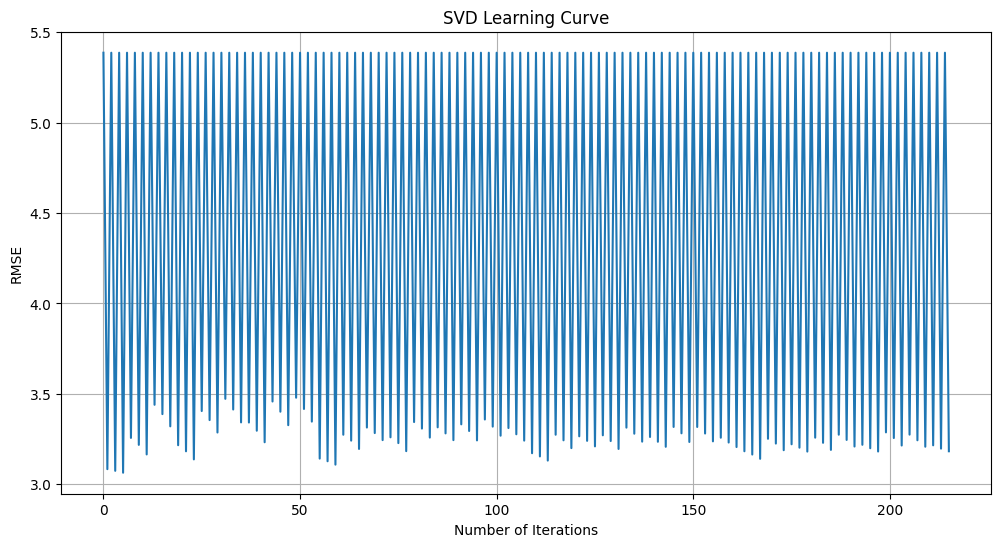

In [0]:
# Plot function to show learning curve of svd

# Tạo một danh sách x từ 0 đến len(errors) - 1
x_values = list(range(len(results)))

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(x_values, results)
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('SVD Learning Curve')
plt.grid(True)
plt.show()

In [0]:
for prediction in predictions:
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Rating: {prediction.est}")

User: ID0998, Item: 37917.0, Rating: 4.883198000056121
User: ID0783, Item: 138.0, Rating: 5.100851668615895
User: ID1018, Item: 61134.0, Rating: 5.465065512748617
User: ID1030, Item: 59817.0, Rating: 5.695940168944638
User: ID1393, Item: 9657.0, Rating: 5.180967809356892
User: ID0772, Item: 51856.0, Rating: 5.195328782846163
User: ID0412, Item: 205.0, Rating: 5.501739193048067
User: ID0480, Item: 11150.0, Rating: 5.294094264152306
User: ID0585, Item: 14409.0, Rating: 5.638147251304502
User: ID0216, Item: 54812.0, Rating: 6.579707414421834
User: ID1702, Item: 18973.0, Rating: 3.1417821905886547
User: ID0321, Item: 5658.0, Rating: 5.814599770835583
User: ID0546, Item: 51576.0, Rating: 5.278629148448274
User: ID0050, Item: 110.0, Rating: 4.3058039490150595
User: ID0966, Item: 504.0, Rating: 5.6037249568687955
User: ID0211, Item: 31167.0, Rating: 6.564470068601182
User: ID0138, Item: 11023.0, Rating: 5.436027603565778
User: ID0799, Item: 3293.0, Rating: 5.4615095961297895
User: ID1085, Ite

In [0]:

# Chuyển đổi PySpark DataFrame thành Pandas DataFrame
pandas_movies_df = movies_df.toPandas()

In [0]:

def get_similar_movies_svd(model, movie_id, movies_df, top_n=10):
    # Lấy inner id của movie
    movie_inner_id = model.trainset.to_inner_iid(movie_id)
    
    # Lấy ma trận nhúng phim
    movie_matrix = model.qi
    
    # Tính độ tương tự
    movie_vector = movie_matrix[movie_inner_id]
    similarity = np.dot(movie_matrix, movie_vector) / (np.linalg.norm(movie_matrix, axis=1) * np.linalg.norm(movie_vector))
    
    # Sắp xếp và chọn top N phim tương tự
    similar_movies = np.argsort(similarity)[::-1][:top_n +3]  
    similar_movies = (model.trainset.to_raw_iid(inner_id) for inner_id in similar_movies if inner_id != movie_inner_id)
    
    # Lấy tên phim từ movies_df
    similar_movies_with_names = movies_df[movies_df['MOVIE_ID'].isin(similar_movies)][['MOVIE_ID', 'MOVIE_NAME']]
    return similar_movies_with_names

# Nhập movie_id để tìm phim tương tự
movie_id = 504
similar_movies = get_similar_movies_svd(best_model, movie_id, pandas_movies_df, top_n=10)
print("Phim tương tự với Movie ID", movie_id)
print(similar_movies)


Phim tương tự với Movie ID 504
     MOVIE_ID              MOVIE_NAME
17   527313.0            Finding Eden
117   20186.0           Better Things
136   72466.0   More Than Just a Game
144   11150.0        Back to Normandy
156   25072.0           Malos hábitos
189   12763.0           Take the Lead
197   30082.0    Forty Shades of Blue
247    3131.0       Gangs of New York
279   37014.0  The Sentimental Teaser
301     454.0          Romeo + Juliet


In [0]:
import pandas as pd

# Chuyển đổi results thành DataFrame
df_results = pd.DataFrame(results)
df_results['n_factors'] = df_results['params'].apply(lambda x: x['n_factors'])
df_results['n_epochs'] = df_results['params'].apply(lambda x: x['n_epochs'])
df_results['lr_all'] = df_results['params'].apply(lambda x: x['lr_all'])
df_results['reg_all'] = df_results['params'].apply(lambda x: x['reg_all'])
df_results['biased'] = df_results['params'].apply(lambda x: x['biased'])

# Tạo pivot table
pivot_table = df_results.pivot_table(index=['n_factors', 'biased'], columns=['n_epochs', 'lr_all', 'reg_all'], values='rmse')
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of RMSE for Different SVD Parameter Configurations')
plt.xlabel('Epochs, Learning Rate, Regularization')
plt.ylabel('Number of Factors, Bias')
plt.show()


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File <command-3875375123877125>, line 5
      3 # Chuyển đổi results thành DataFrame
      4 df_results = pd.DataFrame(results)
----> 5 df_results['n_factors'] = df_results['params'].apply(lambda x: x['n_factors'])
      6 df_results['n_epochs'] = df_results['params'].apply(lambda x: x['n_epochs'])
      7 df_results['lr_all'] = df_results['params'].apply(lambda x: x['lr_all'])

File /databricks/python/lib/python3.10/site-packages/pandas/core/frame.py:3505, in DataFrame.__getitem__(self, key)
   3503 if self.columns.nlevels > 1:
   3504     return self._getitem_multilevel(key)
-> 3505 indexer = self.columns.get_loc(key)
   3506 if is_integer(indexer):
   3507     indexer = [indexer]

File /databricks/python/lib/python3.10/site-packages/pandas/core/indexes/range.py:389, in RangeIndex.get_loc(self, key, method, tolerance)
    387         